In [15]:
import tifffile
import numpy as np
import napari
import matplotlib.pyplot as plt

import zarr
import pandas as pd

In [2]:
import dask
from dask.distributed import Client
client = Client() # using local computer
client # view tasks being processed by dask


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 255.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61980,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 255.25 GiB
Comm: tcp://127.0.0.1:62031,Total threads: 6
Dashboard: http://127.0.0.1:62032/status,Memory: 31.91 GiB
Nanny: tcp://127.0.0.1:61983,


In [3]:
from bigstream.align import alignment_pipeline
from bigstream.transform import apply_transform
from bigstream.piecewise_align import distributed_piecewise_alignment_pipeline
from bigstream.piecewise_transform import distributed_apply_transform


In [8]:
####################
## the stitched N5 data has been padded (ie. empty tile has been filled in with white noise) and saved as tiff ##

fix = tifffile.imread('//nrs.hhmi.org/liu/Hippo_rawtiff/DAPI_s2/padded/stitch_t15_c3_s2_padded.tiff')
mov = tifffile.imread('//nrs.hhmi.org/liu/Hippo_rawtiff/DAPI_s2/padded/stitch_t04_c3_s2_padded.tiff')
print(fix.shape,mov.shape)


(185, 2469, 4341) (416, 2525, 4374)


In [13]:
# use napari to look at the two DAPI data
# use subsampling of 8,4,4, the images have lots of data, but we don't actually need to see all of the data points

fix_img = fix[::8,::4,::4]
mov_img = mov[::8,::4,::4]

viewer = napari.Viewer()
viewer.add_image(fix_img,colormap='reds',opacity=0.4, blending='additive')
viewer.add_image(mov_img,colormap='blues',opacity=0.4, blending='additive')

<Image layer 'mov_img' at 0x24a178d7ee0>

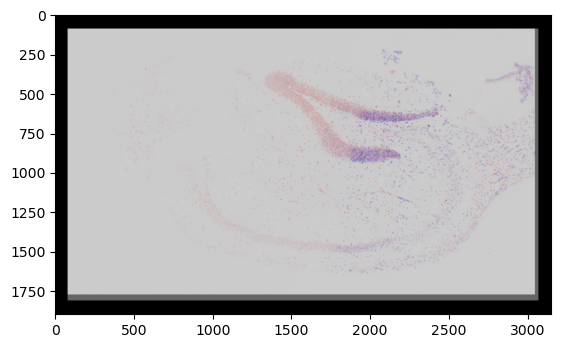

In [26]:
# view snapshot
shot = viewer.screenshot()
plt.imshow(shot) 
# blue=mov, is tilted compared to fix, also indicated by much larger z in mov.shape

In [11]:
from bigstream.align import alignment_pipeline

# xy pixel resolution of s0 is 0.163nm, s2 is 4x downsampled, so 0.652nm. Bigstitcher outputs upscaled z to make isotropic data
spacing = np.array([0.652, 0.652, 0.652])

affine_kwargs = {
    'alignment_spacing':2.0,  # subsampling factor for computing matrix
    'shrink_factors':(2,), # downsampling factor
    'smooth_sigmas':(2.,),
    'optimizer_args':{
        'learningRate':0.25,
        'minStep':0.,
        'numberOfIterations':1000,
    },
}


In [32]:
# get affine matrix
affine = alignment_pipeline(
    fix, mov,
    spacing, spacing, # same spacing for both data
    steps=[('affine',affine_kwargs)],
)

# save results
np.savetxt('./_hippo_bigstream_v3/transformation/affine.mat', affine)

## this is the transformation matrix for mov data such that after transfomration it aligns with fix data
## this matrix will be used to transform other channels

Fri Apr 26 14:23:36 2024 Run affine {'alignment_spacing': 2.0, 'shrink_factors': (2,), 'smooth_sigmas': (2.0,), 'optimizer_args': {'learningRate': 0.25, 'minStep': 0.0, 'numberOfIterations': 1000}}
LEVEL:  0  ITERATION:  0  METRIC:  -0.023640319177806964
LEVEL:  0  ITERATION:  1  METRIC:  -0.023958292662904376
LEVEL:  0  ITERATION:  2  METRIC:  -0.02421235605632688
LEVEL:  0  ITERATION:  3  METRIC:  -0.02449148765826225
LEVEL:  0  ITERATION:  4  METRIC:  -0.024808480997802883
LEVEL:  0  ITERATION:  5  METRIC:  -0.025072377579974433
LEVEL:  0  ITERATION:  6  METRIC:  -0.025281832257260703
LEVEL:  0  ITERATION:  7  METRIC:  -0.025429867223149803
LEVEL:  0  ITERATION:  8  METRIC:  -0.02557944416453058
LEVEL:  0  ITERATION:  9  METRIC:  -0.0258233056388049
LEVEL:  0  ITERATION:  10  METRIC:  -0.026100452948532922
LEVEL:  0  ITERATION:  11  METRIC:  -0.026338302632296695
LEVEL:  0  ITERATION:  12  METRIC:  -0.02651163026272193
LEVEL:  0  ITERATION:  13  METRIC:  -0.026652033708270954
LEVEL:

In [33]:
# load result
affine = np.loadtxt('./_hippo_bigstream_v3/transformation/affine.mat')

from bigstream.transform import apply_transform

# apply the transform to the moving data to resample it
affined = apply_transform(
    fix, mov, 
    spacing, spacing,
    transform_list=[affine,], # only doing affine
)


In [34]:
# use napari to look at the two DAPI data
# use subsampling of 8,4,4, the images have lots of data, but we don't actually need to see all of the data points

fix_img = fix[::8,::4,::4]
affined_img = affined[::8,::4,::4]

viewer = napari.Viewer()
viewer.add_image(fix_img,colormap='reds',opacity=0.4, blending='additive')
viewer.add_image(affined_img,colormap='blues',opacity=0.4, blending='additive')

<Image layer 'affined_img' at 0x24a3a74a560>

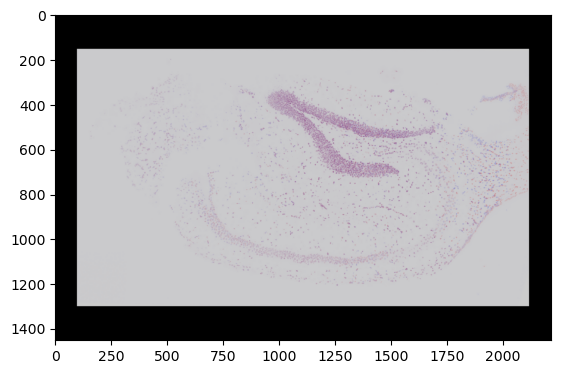

In [35]:
# view snapshot
shot = viewer.screenshot()
plt.imshow(shot) 
# much better than original, but still many misaligned nuclei
# we will do deformable transformation

In [37]:
deform_kwargs = {
    'alignment_spacing':2.0,
    'shrink_factors':(2,),
    'smooth_sigmas':(0.25,),
    'control_point_spacing':128.0,
    'control_point_levels':(1,),
    'optimizer_args':{
        'learningRate':0.25,
        'minStep':0.,
        'numberOfIterations':100,
    },
}

################## dask ################
blocksize = [64,128,128]
cluster_kwargs = {
    'n_workers':20, # I have 24 cores, 48 logical processors
    'threads_per_worker':2, # per worker, 20x2 threads, leaves me with 4 cores and 8 threads
    'memory_limit':'10GB', # per worker, 200 memory total, which is less than 255GB memory available on my pc
}


In [38]:
from bigstream.piecewise_align import distributed_piecewise_alignment_pipeline

# get deform matrix using distributed with affine matrix initialization
# memory can't hold the entire deform matrix
deform = distributed_piecewise_alignment_pipeline(
    fix, mov,
    spacing, spacing,
    steps=[('deform',deform_kwargs)], # perform deform step
    static_transform_list=[affine,],  # initialize with affine matrix
    blocksize=blocksize,
    write_path='./_hippo_bigstream_v3/transformation/deform.zarr',
    cluster_kwargs=cluster_kwargs,
)
deform.info
# this will output deform matrix in zarr format.
# deform has the same dimensions as the image + extra dimension with 3 elements (xyz vectors)

C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54420 instead
  warnings.warn(


Type,zarr.core.Array
Data type,float32
Shape,"(185, 2469, 4341, 3)"
Chunk shape,"(64, 128, 128, 3)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,23793802380 (22.2G)
No. bytes stored,17770079718 (16.5G)
Storage ratio,1.3


In [39]:
from bigstream.piecewise_transform import distributed_apply_transform

affine_path = './_hippo_bigstream_v3/transformation/affine.mat'
affine = np.loadtxt(affine_path)
deform_path = './_hippo_bigstream_v3/transformation/deform.zarr'
deform = zarr.open(deform_path, mode='r')


# transform using affine and deform
affine_deformed = distributed_apply_transform(
    fix, mov,
    spacing, spacing,
    transform_list=[affine,deform], # sequential steps, affine and then deform
    blocksize=blocksize,
    write_path='./_hippo_bigstream_v3/warped/warped.zarr',
    cluster_kwargs=cluster_kwargs,
)

tifffile.imwrite('./_hippo_bigstream_v3/warped/warped.tiff', affine_deformed, imagej=True, metadata={'axes':'ZYX'})


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63869 instead
  warnings.warn(


In [42]:
# use napari to look at the two DAPI data
# use subsampling of 8,4,4, the images have lots of data, but we don't actually need to see all of the data points

fix_img = fix[::8,::4,::4]
warped_img = affine_deformed[::8,::4,::4]

viewer = napari.Viewer()
viewer.add_image(fix_img,colormap='reds',opacity=0.4, blending='additive')
viewer.add_image(warped_img,colormap='blues',opacity=0.4, blending='additive')

<Image layer 'warped_img' at 0x24a3fb8beb0>

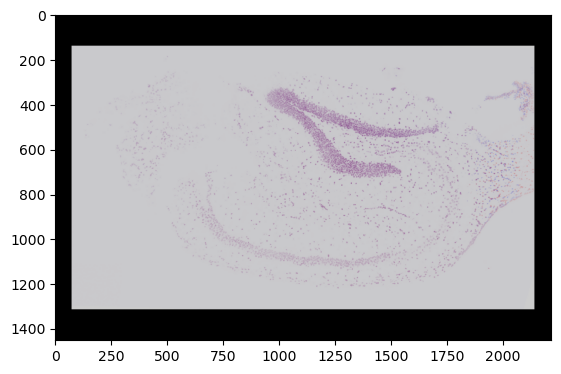

In [41]:
# view snapshot
shot = viewer.screenshot()
plt.imshow(shot) 
# looks much better than affine alone

In [43]:
# we will use the affine and deform matrix to register other channels from the same timepoint

# read transformation matrices
affine_path = './_hippo_bigstream_v3/transformation/affine.mat'
affine = np.loadtxt(affine_path)
deform_path = './_hippo_bigstream_v3/transformation/deform.zarr'
deform = zarr.open(deform_path, mode='r')

# fix data doesn't change
fix = tifffile.imread('//nrs.hhmi.org/liu/Hippo_rawtiff/DAPI_s2/padded/stitch_t15_c3_s2_padded.tiff')

# for mov data, we will use N5 output from bigstitcher
# padding matters for finding registration matrix, but padding is not necessary for transforming other channels
setdir = '//nrs.hhmi.org/liu/Jun/output_val_onetile_set1_re1/'
n5dir = setdir+'/easi/dataset-t4/stitching/export.n5/'     # read directly from t4 of set1

C = [0,1,2,3] # we will transform all channels
for c in C:
    subpath = 'c'+str(c)+'/s2'   # read channel and s2 resolution
    mov_zarr = zarr.open(store=zarr.N5Store(n5dir), mode='r')
    mov = np.array(mov_zarr[subpath]).squeeze()

    out_name='./_hippo_bigstream_v3/warped/warped_'+str(c)
    print(subpath,'::::',out_name)
    affine_deformed = distributed_apply_transform(
        fix, mov,
        spacing, spacing,
        transform_list=[affine,deform],
        blocksize=blocksize,
        write_path=out_name+'.zarr',
        cluster_kwargs=cluster_kwargs,
    )

    # we noticed some regions don't have any cells, we will manually crop them out when saving as tiff
    # it's important to keep the cropping elements the same
    tifffile.imwrite(out_name+'_crop.tiff', affine_deformed[30:139, 150:2328, 265:4341], imagej=True, metadata={'axes':'ZYX'}) 


c0/s2 :::: ./_hippo_bigstream_v3/warped/warped_0


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55972 instead
  warnings.warn(


c1/s2 :::: ./_hippo_bigstream_v3/warped/warped_1


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56443 instead
  warnings.warn(


c2/s2 :::: ./_hippo_bigstream_v3/warped/warped_2


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56938 instead
  warnings.warn(


c3/s2 :::: ./_hippo_bigstream_v3/warped/warped_3


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap_bigstream\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57401 instead
  warnings.warn(


In [44]:
# crop the fix image the same way, just to check in fiji
tifffile.imwrite('./_hippo_bigstream_v3/stitch_t15_c3_s2_padded_crop.tiff', fix[30:139, 150:2328, 265:4341], imagej=True, metadata={'axes':'ZYX'})